In [ ]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy

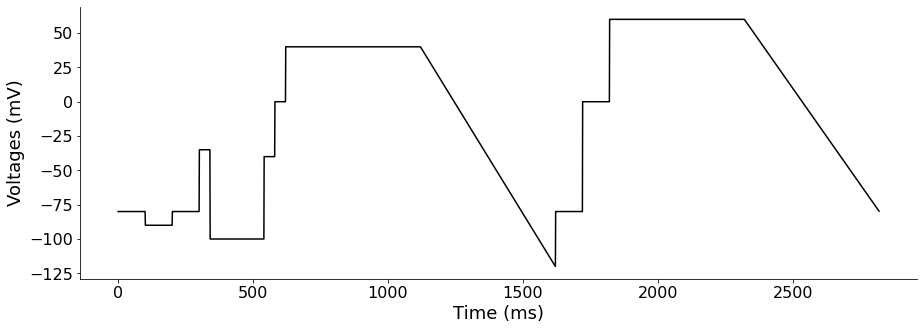

In [ ]:
'''
Method 1
'''
VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps

VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-100, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=500)) # ramp step
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=500)) # ramp step

times = np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 1) 
VC_protocol.plot_voltage_clamp_protocol(times)

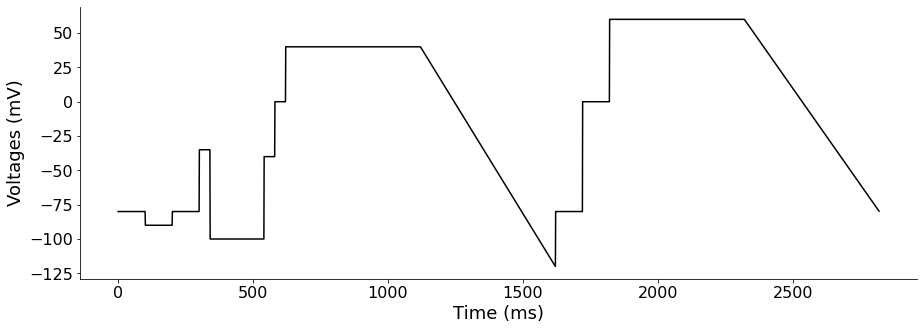

In [ ]:
'''
Method 2
'''
steps = []
steps.append( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )  # #  1e-14
steps.append( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
steps.append( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
steps.append( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
steps.append( protocol_lib.VoltageClampStep(voltage=-100, duration=200) )
steps.append( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
steps.append( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  ## ??? why??
steps.append( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
steps.append( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=500)) # ramp step
steps.append( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
steps.append( protocol_lib.VoltageClampStep(voltage=0, duration=100) )  ## ??? why??
steps.append( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
steps.append( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=500)) # ramp step

VC_protocol = protocol_lib.VoltageClampProtocol(steps)  # steps=steps

times = np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 1) 
VC_protocol.plot_voltage_clamp_protocol(times)

In [ ]:

simulation_library = 'scipy'


In [8]:
from ord2011 import ORD2011
from br1977 import BR1977

start_time = time.time()

sim = None
if simulation_library == 'myokit':
    model, p, s = myokit.load("../mmt-model-files/ord-2011_VC _JKv1.mmt" )    
    sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=-80)  # 1e-12, 1e-14  # 1e-08, 1e-10
    sim.name = "ORD2011"    
    
elif simulation_library == 'scipy' :    
    model = ORD2011(VC_protocol)
    sim = simulator_scipy.Simulator(model)
    
print("--- %s seconds ---"%(time.time()-start_time))

--- 3.426259756088257 seconds ---


In [9]:
start_time = time.time()

sol = {}
if simulation_library == 'myokit':    
    # sim.simulation.set_constant('cell.mode', 1)    
    y0 = sim.pre_simulate(5000, sim_type=1)
    d = sim.simulate(VC_protocol.get_voltage_change_endpoints()[-1], log_times=None, extra_log=['ina.INa', 'ikr.IKr', 'iks.IKs', 'ito.Ito', 'ical.ICaL', 'ik1.IK1', 'inal.INaL'])
    
    times = d['engine.time']
    sol["Voltage"] = d['membrane.V']
    sol["I_Na"] = d['ina.INa']
    sol["I_Kr"] = d['ikr.IKr']
    sol["I_Ks"] = d['iks.IKs']
    sol["I_To"] = d['ito.Ito']
    sol["I_CaL"] = d['ical.ICaL']
    sol["I_K1"] = d['ik1.IK1']
    sol["I_NaL"] = d['inal.INaL']
         
elif simulation_library == 'scipy':
    # model.cell.mode = 1    
    y0 = sim.pre_simulate( protocol='constant', pre_step=5000, v0=-80 )   
    d = sim.simulate(t_span=[0, VC_protocol.get_voltage_change_endpoints()[-1]], t_eval=None, method='BDF', max_step=1, atol=1e-06, rtol=1e-6) # 1e-12, 1e-14  # 1e-08, 1e-10
    
    times = d.t
    sol["Voltage"] = d.y[0]
    sol["I_Na"] = sim.model.current_response_info.get_current(['I_Na'])
    sol["I_Kr"] = sim.model.current_response_info.get_current(['I_Kr'])
    sol["I_Ks"] = sim.model.current_response_info.get_current(['I_Ks'])
    sol["I_To"] = sim.model.current_response_info.get_current(['I_To'])
    sol["I_CaL"] = sim.model.current_response_info.get_current(['I_CaL'])
    sol["I_K1"] = sim.model.current_response_info.get_current(['I_K1'])
    sol["I_NaL"] = sim.model.current_response_info.get_current(['I_NaL'])
            
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.3593451976776123 seconds ---


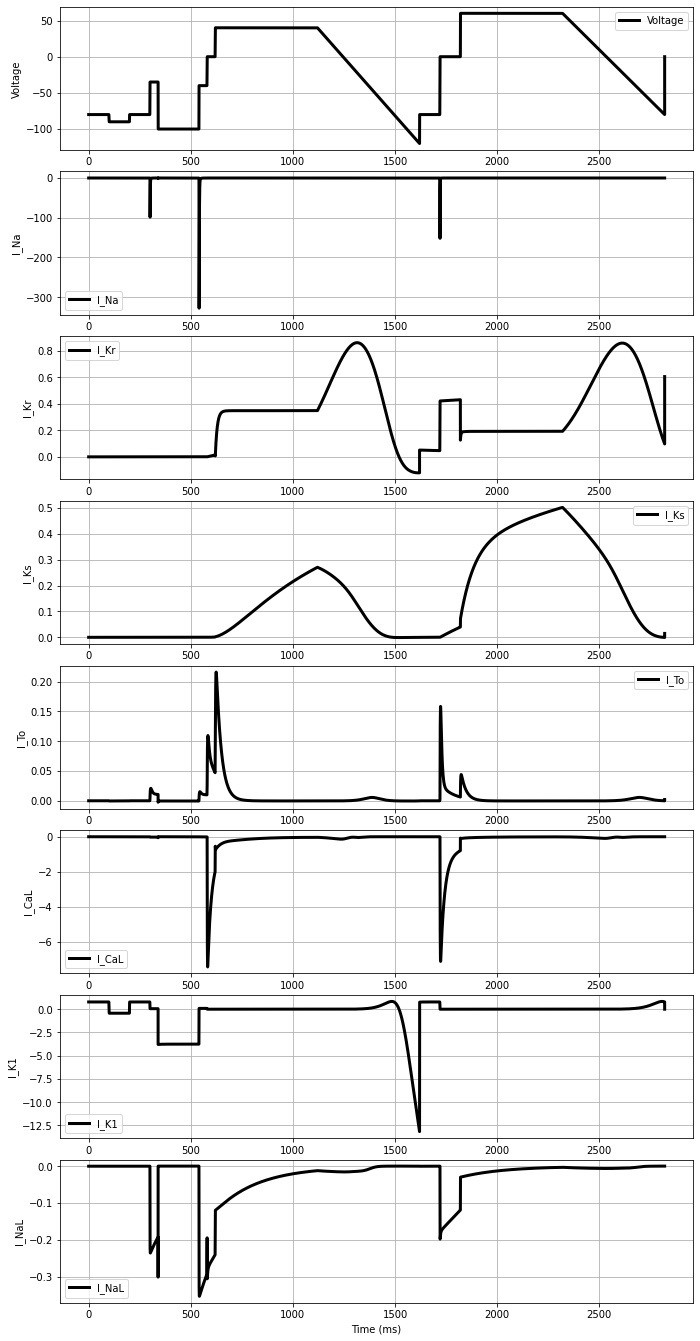

In [10]:
'''
Plot
'''
fig, ax = plt.subplots(8,1, figsize=(10,20))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times, values, label=name, color='k', linewidth=3)     
    ax[i].legend()
    ax[i].grid()

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join('Results', "Make_vc_protocol.jpg"), dpi=100)